In [ ]:
# Gerekli kütüphaneleri içe aktarın

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input , models , layers
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
import spacy
import matplotlib.pyplot as plt


In [ ]:
new_df = pd.read_csv("/content/aug_dataset.csv")

In [ ]:
# Veri setindeki benzersiz kelimeleri ve etiketleri alın

words = list(set(new_df['word'].values))
words.append('ENDPAD') # Son eklenen dolgu kelimesi
num_words = len(words)

In [ ]:
tags = list(set(new_df['label'].values))
num_tags = len(tags)


In [ ]:
# Kelime ve etiket sayısını yazdırın

num_words, num_tags

(2254, 5)

In [ ]:
# Cümle alıcı sınıfını tanımlayın

class SentenceGetter(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        agg_func = lambda s: [(w, t) for w, t in zip(s['word'].values.tolist(),
                                                          s['label'].values.tolist())]
        self.grouped = self.df.groupby('sentence_id').apply(agg_func)
        self.sentences = [s for s in self.grouped]


In [ ]:
getter = SentenceGetter(new_df)
sentences = getter.sentences


In [ ]:
sentences[0]


[('BİLATERAL', 'O'),
 ('MAMOGRAFİ', 'O'),
 ('İNCELEMESİ', 'O'),
 ('Her', 'O'),
 ('iki', 'ANAT'),
 ('memenin', 'ANAT'),
 ('cilt', 'O'),
 ('yüzeyi', 'ANAT'),
 ('normal', 'O'),
 ('olarak', 'O'),
 ('değerlendirilmiş', 'O'),
 ('olup', 'O'),
 ('kalınlaşma', 'O'),
 ('ve', 'O'),
 ('retraksiyon', 'O'),
 ('saptanmamıştır', 'O'),
 ('Her', 'O'),
 ('iki', 'ANAT'),
 ('meme', 'ANAT'),
 ('liposkleroze', 'O'),
 ('paternde', 'O'),
 ('izlenmektedir', 'O'),
 ('Her', 'O'),
 ('iki', 'O'),
 ('meme', 'ANAT'),
 ('belirgin', 'O'),
 ('dens', 'OBS-PRESENT'),
 ('yapıdadır', 'O'),
 ('Sol', 'OBS-PRESENT'),
 ('memede', 'O'),
 ('alt', 'ANAT'),
 ('dış', 'O'),
 ('kadranda', 'ANAT'),
 ('lineer', 'O'),
 ('dizilimli', 'ANAT'),
 ('ince', 'ANAT'),
 ('çizgisel', 'O'),
 ('kalsifikasyonlar', 'O'),
 ('izlendi', 'O'),
 ('Her', 'O'),
 ('iki', 'O'),
 ('aksillada', 'ANAT'),
 ('patolojik', 'O'),
 ('lenf', 'OBS-ABSENT'),
 ('bezi', 'OBS-ABSENT'),
 ('izlenmemektedir', 'O'),
 ('SONUÇ', 'O'),
 ('BIRADS', 'O'),
 ('5', 'O')]

In [ ]:
# Kelime ve etiketlere dizin oluşturun

word2idx = {w: i+1 for i, w in enumerate(words)} # 0'a END pad eklendi
tag2idx = {t: i for i, t in enumerate(tags)}

Mean length: 70.34759825327511
Median length: 65.0
90th percentile length: 108.0
95th percentile length: 117.0
99th percentile length: 153.0


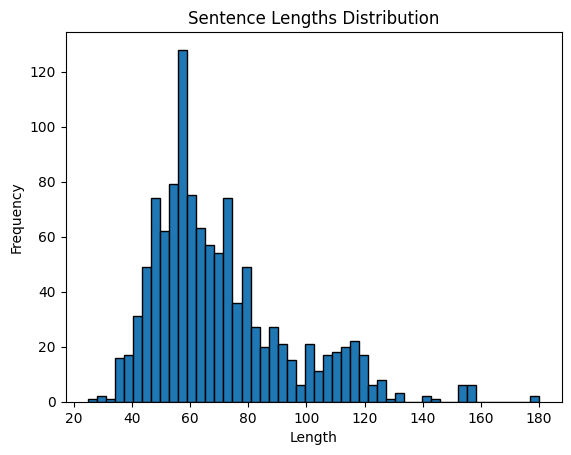

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate sentence lengths
sentence_lengths = [len(s) for s in sentences]

# Display statistics
print(f'Mean length: {np.mean(sentence_lengths)}')
print(f'Median length: {np.median(sentence_lengths)}')
print(f'90th percentile length: {np.percentile(sentence_lengths, 90)}')
print(f'95th percentile length: {np.percentile(sentence_lengths, 95)}')
print(f'99th percentile length: {np.percentile(sentence_lengths, 99)}')

# Plot histogram
plt.hist(sentence_lengths, bins=50, edgecolor='black')
plt.title('Sentence Lengths Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Calculate lengths of all sentences
sentence_lengths = [(len(s), s) for s in sentences]

# Find the maximum length and the corresponding sentence
max_length_sentence = max(sentence_lengths, key=lambda x: x[0])

# Extract the maximum length and the sentence
max_length = max_length_sentence[0]
max_length_sentence = max_length_sentence[1]

print(f'Maximum length: {max_length}')
print(f'Sentence with maximum length: {max_length_sentence}')

Maximum length: 180
Sentence with maximum length: [('BİLATERAL', 'O'), ('İKİ', 'O'), ('YÖNLÜ', 'O'), ('MAMOGRAMLARDA', 'O'), ('Sağda', 'ANAT'), ('cilt', 'ANAT'), ('cilt', 'O'), ('altı', 'ANAT'), ('yağ', 'ANAT'), ('dokusu', 'ANAT'), ('ve', 'O'), ('sağ', 'O'), ('meme', 'ANAT'), ('başı', 'ANAT'), ('doğaldır', 'O'), ('Sol', 'O'), ('meme', 'ANAT'), ('başı', 'ANAT'), ('hafif', 'O'), ('retrakte', 'OBS-PRESENT'), ('görünümdedir', 'O'), ('Liposkleroze', 'O'), ('meme', 'O'), ('paterni', 'ANAT'), ('izlenmektedir', 'O'), ('Solda', 'O'), ('orta', 'ANAT'), ('hatta', 'ANAT'), ('meme', 'ANAT'), ('başına', 'ANAT'), ('yaklaşık', 'ANAT'), ('3.5', 'ANAT'), ('cm', 'ANAT'), ('uzaklıkta', 'ANAT'), ('tetkik', 'O'), ('alanına', 'O'), ('girdiği', 'O'), ('kadarı', 'O'), ('ile', 'O'), ('5.5', 'O'), ('x', 'O'), ('2.2', 'OBS-PRESENT'), ('cm', 'OBS-PRESENT'), ('çapında', 'OBS-PRESENT'), ('düzensiz', 'O'), ('sınırlı', 'OBS-PRESENT'), ('spiküle', 'O'), ('konturlu', 'OBS-PRESENT'), ('yüksek', 'O'), ('dansiteli', 'OBS-P

In [ ]:
# Maksimum cümle uzunluğunu belirtin ve cümleleri ve etiketleri diziye dönüştürün

max_len = 200
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]  # Use w[1] for the label
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx['O'])
y = [to_categorical(i, num_classes=num_tags) for i in y]


In [ ]:
len(X)

1145

In [ ]:
# Eğitim ve test veri setlerini ayırın

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)


In [ ]:
# Splitting the remaining x_train and y_train into a smaller subset
x_train_remain, x_train_small, y_train_remain, y_train_small = train_test_split(x_train, y_train, test_size=250, random_state=1)

In [ ]:
from tensorflow.keras.regularizers import l2

# Modelin yapısını tanımlayın
input_word = Input(shape=(max_len,))  # Define model input
model = Embedding(input_dim=num_words, output_dim=max_len)(input_word)
model = SpatialDropout1D(0.3)(model)  # Increased dropout rate
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)  # Define the model
model.summary()  # Print model summary

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 200)          450800    
                                                                 
 spatial_dropout1d (Spatial  (None, 200, 200)          0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 200, 200)          240800    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 200, 5)            1005      
 ributed)                                                        
                                                             

In [ ]:
import tensorflow.keras.backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall, f1_score])


In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=6, verbose=0, mode='max', restore_best_weights=False)


# Fit the model with class weights
history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.1,
    batch_size=16,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50
58/58 [==============================] - 67s 1s/step - loss: 3.1041 - accuracy: 0.8275 - precision: 0.7935 - recall: 0.6949 - f1_score: 0.7355 - val_loss: 1.1445 - val_accuracy: 0.8478 - val_precision: 0.8502 - val_recall: 0.8490 - val_f1_score: 0.8496
Epoch 2/50
58/58 [==============================] - 56s 960ms/step - loss: 0.7066 - accuracy: 0.8378 - precision: 0.8790 - recall: 0.7972 - f1_score: 0.8354 - val_loss: 0.4459 - val_accuracy: 0.8478 - val_precision: 0.9227 - val_recall: 0.7836 - val_f1_score: 0.8474
Epoch 3/50
58/58 [==============================] - 52s 899ms/step - loss: 0.4327 - accuracy: 0.8386 - precision: 0.9018 - recall: 0.7836 - f1_score: 0.8378 - val_loss: 0.3646 - val_accuracy: 0.8499 - val_precision: 0.8948 - val_recall: 0.8211 - val_f1_score: 0.8564
Epoch 4/50
58/58 [==============================] - 53s 917ms/step - loss: 0.3602 - accuracy: 0.8536 - precision: 0.9144 - recall: 0.7970 - f1_score: 0.8515 - val_loss: 0.3184 - val_accuracy: 0.8726 - v

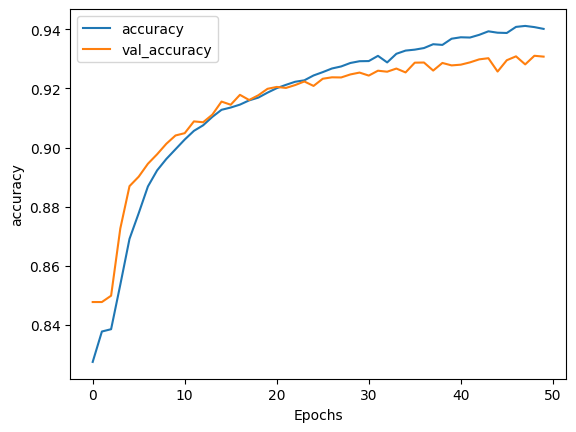

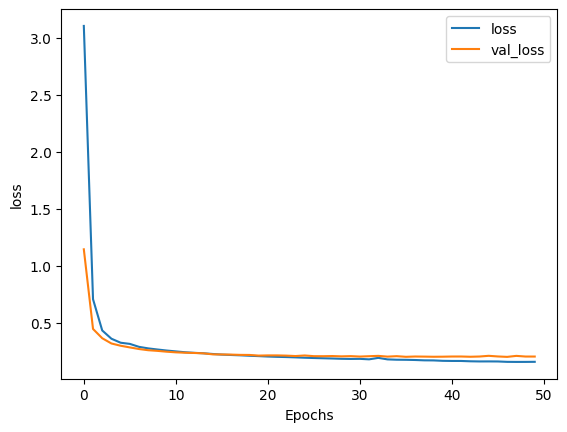

In [ ]:
# Grafik çizim fonksiyonunu tanımlayın

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# Eğitim geçmişini görselleştirin
plot_graphs(history, "accuracy")
plot_graphs(history, "loss");


In [ ]:
# Define a function to prepare new sentences for prediction
def prepare_sentences(sentences, word2idx, max_len):
    # Tokenize and pad the input sentences
    X_pred = [[word2idx.get(w, word2idx['ENDPAD']) for w in s] for s in sentences]
    X_pred = pad_sequences(maxlen=max_len, sequences=X_pred, padding='post', value=len(word2idx)-1)
    return X_pred

# Example sentence to test
test_sentence = "meme kanseri tespit edilememiştir"
test_sentence_tokens = test_sentence.split()

# Prepare the test sentence using the same `prepare_sentences` function
X_pred = prepare_sentences([test_sentence_tokens], word2idx, max_len)

# Make predictions
predictions = model.predict(X_pred)

# Assuming `predictions` is a numpy array of shape (1, max_len, num_tags)
# Decode predictions to get the labels
decoded_predictions = []

for j in range(len(predictions[0])):
    predicted_tag_idx = np.argmax(predictions[0][j])
    predicted_tag = tags[predicted_tag_idx]
    decoded_predictions.append(predicted_tag)

# Print the predictions
print(f"Sentence: {test_sentence}")
print(f"Predicted Labels: {decoded_predictions}")

1/1 [==============================] - 1s 618ms/step
Sentence: meme kanseri tespit edilememiştir
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

In [ ]:
x_train_small , y_train_small

In [ ]:
model.evaluate(x_train_small, np.array(y_train_small))


8/8 [==============================] - 1s 136ms/step - loss: 0.1487 - accuracy: 0.9471 - precision: 0.9500 - recall: 0.9438 - f1_score: 0.9469


[0.14870044589042664,
 0.9470800161361694,
 0.950011134147644,
 0.943793535232544,
 0.946891725063324]

In [ ]:
model.evaluate(x_test, np.array(y_test))


4/4 [==============================] - 1s 133ms/step - loss: 0.1683 - accuracy: 0.9383 - precision: 0.9426 - recall: 0.9359 - f1_score: 0.9393


[0.16830432415008545,
 0.9383478164672852,
 0.9426376223564148,
 0.9359415769577026,
 0.9392775297164917]

In [ ]:
# Tüm varlıkları sıralayın

all_entities = sorted(new_df.label.unique().tolist())


In [ ]:
from sklearn.metrics import confusion_matrix , classification_report

# Predict labels for the test data
y_pred = model.predict(x_test)

# Example conversion if predictions are probabilities
# Adjust this part based on how your model outputs predictions
y_pred = np.argmax(y_pred, axis=-1)

# Convert one-hot encoded y_test to indices
y_test_indices = np.argmax(y_test, axis=-1)

# Check the shapes and types of y_pred and y_test_indices
print(f"y_pred shape: {np.shape(y_pred)}")
print(f"y_test_indices shape: {np.shape(y_test_indices)}")

# Flatten the predictions and true labels
y_pred_flat = [label for seq in y_pred for label in seq]
y_test_flat = [label for seq in y_test_indices for label in seq]

# Ensure all labels are strings to avoid unhashable type issues
y_pred_flat = [str(label) for label in y_pred_flat]
y_test_flat = [str(label) for label in y_test_flat]

# Check a few entries to verify correctness
print(f"Sample y_pred_flat: {y_pred_flat[:10]}")
print(f"Sample y_test_flat: {y_test_flat[:10]}")

# Get all unique labels
all_entities = sorted(set(y_test_flat).union(set(y_pred_flat)))

# Create a mapping from labels to indices
label_to_index = {label: idx for idx, label in enumerate(all_entities)}
y_test_indices = [label_to_index[label] for label in y_test_flat]
y_pred_indices = [label_to_index[label] for label in y_pred_flat]


target_names = ["O","ANAT","OBS-ABSENT","OBS-PRESENT","OBS-UNCERTAIN"]


# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_indices, y_pred_indices)

# Convert confusion matrix to DataFrame for better readability
conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)

print("Confusion Matrix:")
print(conf_matrix_df)

# Additionally, you can get a classification report
print("\nClassification Report:")
print(classification_report(y_test_indices, y_pred_indices, target_names=target_names))

4/4 [==============================] - 1s 130ms/step
y_pred shape: (115, 200)
y_test_indices shape: (115, 200)
Sample y_pred_flat: ['0', '0', '0', '1', '1', '0', '0', '0', '1', '1']
Sample y_test_flat: ['0', '0', '0', '1', '1', '2', '3', '0', '1', '0']
Confusion Matrix:
                   O  ANAT  OBS-ABSENT  OBS-PRESENT  OBS-UNCERTAIN
O              18963   276         127          174             11
ANAT             255  1190           5            9              3
OBS-ABSENT        75     2         598            0              0
OBS-PRESENT      419    30           4          788              9
OBS-UNCERTAIN     12     2           0            5             43

Classification Report:
               precision    recall  f1-score   support

            O       0.96      0.97      0.97     19551
         ANAT       0.79      0.81      0.80      1462
   OBS-ABSENT       0.81      0.89      0.85       675
  OBS-PRESENT       0.81      0.63      0.71      1250
OBS-UNCERTAIN       0.65   

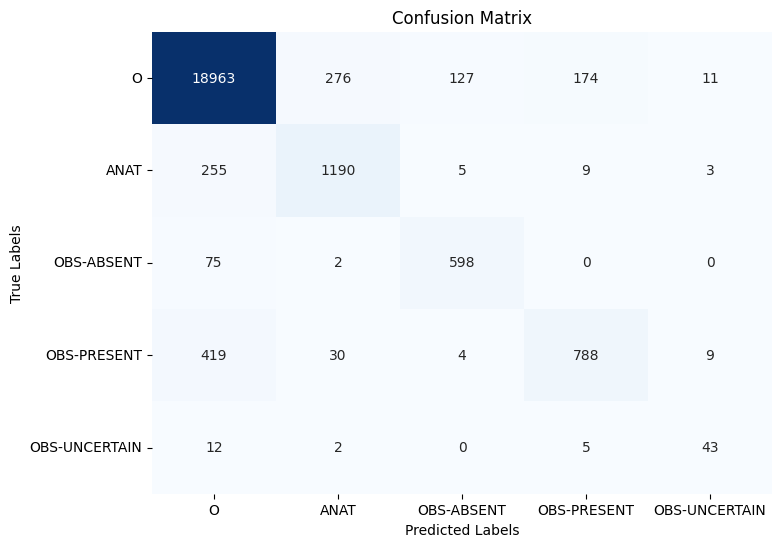

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, cmap="Blues", fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

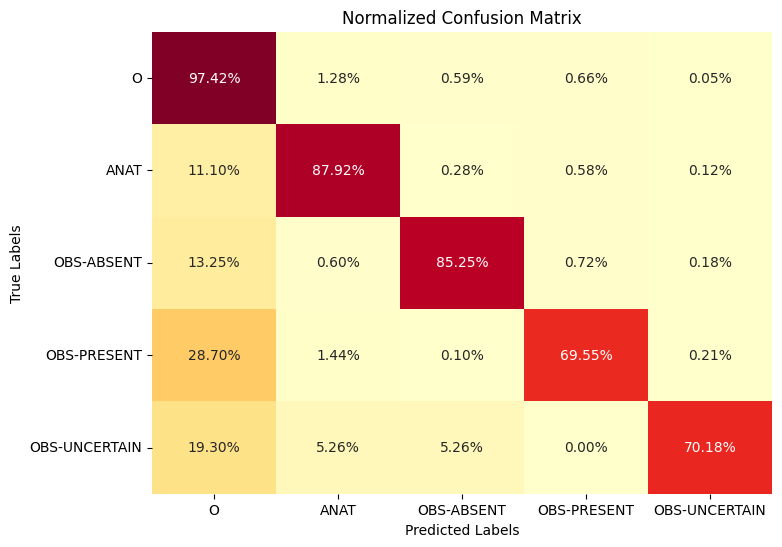

In [ ]:
# Normalize confusion matrix
conf_matrix2 = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Convert confusion matrix to DataFrame for better readability
conf_matrix_df2 = pd.DataFrame(conf_matrix2, index=target_names, columns=target_names)

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df2, annot=True, fmt='.2%', cmap='YlOrRd', cbar=False)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report

# Predict labels for the test data
y_pred = model.predict(x_train_small)

# Example conversion if predictions are probabilities
# Adjust this part based on how your model outputs predictions
y_pred = np.argmax(y_pred, axis=-1)

# Convert one-hot encoded y_test to indices
y_test_indices = np.argmax(y_train_small, axis=-1)

# Check the shapes and types of y_pred and y_test_indices
print(f"y_pred shape: {np.shape(y_pred)}")
print(f"y_test_indices shape: {np.shape(y_test_indices)}")

# Flatten the predictions and true labels
y_pred_flat = [label for seq in y_pred for label in seq]
y_test_flat = [label for seq in y_test_indices for label in seq]

# Ensure all labels are strings to avoid unhashable type issues
y_pred_flat = [str(label) for label in y_pred_flat]
y_test_flat = [str(label) for label in y_test_flat]

# Check a few entries to verify correctness
print(f"Sample y_pred_flat: {y_pred_flat[:10]}")
print(f"Sample y_test_flat: {y_test_flat[:10]}")

# Get all unique labels
all_entities = sorted(set(y_test_flat).union(set(y_pred_flat)))

# Create a mapping from labels to indices
label_to_index = {label: idx for idx, label in enumerate(all_entities)}
y_test_indices = [label_to_index[label] for label in y_test_flat]
y_pred_indices = [label_to_index[label] for label in y_pred_flat]

target_names = ["O","ANAT","OBS-ABSENT","OBS-PRESENT","OBS-UNCERTAIN"]


# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_indices, y_pred_indices)

# Convert confusion matrix to DataFrame for better readability
conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)

print("Confusion Matrix:")
print(conf_matrix_df)

# Additionally, you can get a classification report
print("\nClassification Report:")
print(classification_report(y_test_indices, y_pred_indices, target_names=target_names))

8/8 [==============================] - 1s 130ms/step
y_pred shape: (250, 200)
y_test_indices shape: (250, 200)
Sample y_pred_flat: ['0', '0', '0', '1', '1', '1', '1', '0', '0', '1']
Sample y_test_flat: ['0', '0', '0', '1', '1', '1', '1', '3', '0', '1']
Confusion Matrix:
                   O  ANAT  OBS-ABSENT  OBS-PRESENT  OBS-UNCERTAIN
O              40953   536         249          277             21
ANAT             362  2868           9           19              4
OBS-ABSENT       221    10        1422           12              3
OBS-PRESENT      838    42           3         2031              6
OBS-UNCERTAIN     22     6           6            0             80

Classification Report:
               precision    recall  f1-score   support

            O       0.97      0.97      0.97     42036
         ANAT       0.83      0.88      0.85      3262
   OBS-ABSENT       0.84      0.85      0.85      1668
  OBS-PRESENT       0.87      0.70      0.77      2920
OBS-UNCERTAIN       0.70   

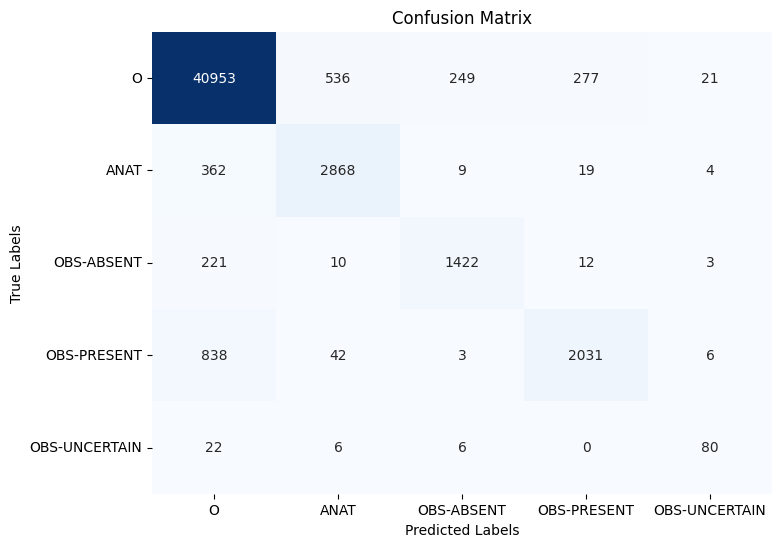

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, cmap="Blues", fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

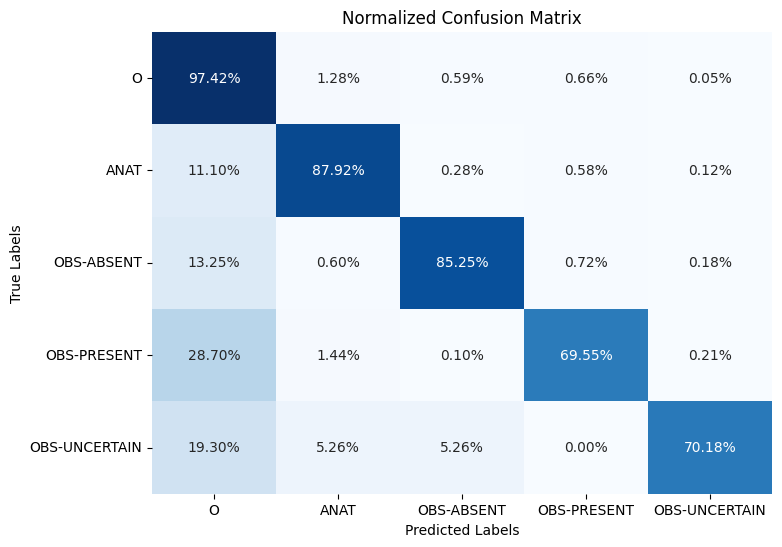

In [ ]:
# Normalize confusion matrix
conf_matrix2 = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Convert confusion matrix to DataFrame for better readability
conf_matrix_df2 = pd.DataFrame(conf_matrix2, index=target_names, columns=target_names)

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df2, annot=True, fmt='.2%', cmap='Blues', cbar=False)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
model.save('my_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Assuming tag2idx is defined like this:
# tag2idx = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, ...}

# Reverse the tag2idx dictionary
idx2tag = {v: k for k, v in tag2idx.items()}

# Get the name of class 3
class_name_3 = idx2tag[4]

print(f"The name of class 3 is: {class_name_3}")


The name of class 3 is: OBS-UNCERTAIN
